In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fetch_stock_data(symbol='CONY', period='2y'):
    """
    Fetch historical stock data from Yahoo Finance

    Args:
        symbol (str): Stock ticker symbol
        period (str): Data period ('1y', '2y', '5y', 'max') - using 5y for more data

    Returns:
        pandas.DataFrame: Historical stock data or None if failed
    """
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period=period)

        if data.empty:
            print(f"No data found for symbol {symbol}")
            return None

        print(f"Fetched {len(data)} days of data for {symbol}")
        return data

    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [3]:
def create_technical_features_fixed(data):
    """
    Create technical indicators WITHOUT data leakage
    All features use ONLY past information

    Args:
        data (pandas.DataFrame): Raw stock data

    Returns:
        tuple: (features_df, target_series, processed_data)
    """
    df = data.copy()

    # CRITICAL FIX: Shift all price-based features by 1 day to avoid data leakage
    # This ensures we only use information available at the time of prediction

    # Use previous day's OHLC data (available at market close)
    df['Prev_Open'] = df['Open'].shift(1)
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)
    df['Prev_Close'] = df['Close'].shift(1)
    df['Prev_Volume'] = df['Volume'].shift(1)

    # Basic price features using PREVIOUS day's data
    df['Price_Change'] = df['Prev_Close'].pct_change()
    df['High_Low_Pct'] = (df['Prev_High'] - df['Prev_Low']) / df['Prev_Close']
    df['Volume_Change'] = df['Prev_Volume'].pct_change()

    # Moving averages using PREVIOUS day's closing prices
    df['MA_5'] = df['Prev_Close'].rolling(window=5).mean()
    df['MA_10'] = df['Prev_Close'].rolling(window=10).mean()
    df['MA_20'] = df['Prev_Close'].rolling(window=20).mean()
    df['MA_50'] = df['Prev_Close'].rolling(window=50).mean()

    # Moving average ratios
    df['MA_5_20_ratio'] = df['MA_5'] / df['MA_20']
    df['MA_10_50_ratio'] = df['MA_10'] / df['MA_50']

    # RSI using previous day's prices
    delta = df['Prev_Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands using previous prices
    df['BB_middle'] = df['Prev_Close'].rolling(window=20).mean()
    bb_std = df['Prev_Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    df['BB_position'] = (df['Prev_Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # MACD using previous prices
    exp1 = df['Prev_Close'].ewm(span=12).mean()
    exp2 = df['Prev_Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    # Volatility using previous prices
    df['Volatility'] = df['Prev_Close'].rolling(window=10).std()

    # Lag features - now properly using past data
    for lag in [2, 3, 5, 10]:  # Start from 2 since we already have 1-day lag
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)

    # Price momentum features
    df['Price_momentum_5'] = df['Prev_Close'] / df['Close'].shift(5) - 1
    df['Price_momentum_20'] = df['Prev_Close'] / df['Close'].shift(20) - 1

    # Volume relative to average
    df['Volume_ratio_20'] = df['Prev_Volume'] / df['Volume'].shift(1).rolling(window=20).mean()

    # Target variable: Today's closing price (what we want to predict)
    # We predict today's close using yesterday's features
    df['Target'] = df['Close']

    # Reduced feature set to avoid overfitting (keeping most predictive ones)
    feature_columns = [
        'Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Volume',
        'Price_Change', 'High_Low_Pct', 'Volume_Change',
        'MA_5', 'MA_20', 'MA_50',
        'MA_5_20_ratio', 'MA_10_50_ratio',
        'RSI', 'BB_position', 'MACD', 'MACD_histogram',
        'Volatility',
        'Close_lag_2', 'Close_lag_5', 'Volume_lag_2',
        'Price_momentum_5', 'Price_momentum_20',
        'Volume_ratio_20'
    ]

    # Remove rows with NaN values (more will be NaN due to proper shifting)
    df_clean = df.dropna()

    features = df_clean[feature_columns]
    target = df_clean['Target']

    print(f"Created {len(feature_columns)} features with {len(df_clean)} valid samples")
    print(f"Removed {len(df) - len(df_clean)} rows due to missing values (this is normal)")

    return features, target, df_clean

In [4]:
def time_series_split(features, target, train_ratio=0.6, val_ratio=0.2):
    """
    Split data chronologically for time series (no shuffling)

    Args:
        features: Feature matrix
        target: Target vector
        train_ratio: Fraction for training
        val_ratio: Fraction for validation

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    n = len(features)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train = features.iloc[:train_end]
    X_val = features.iloc[train_end:val_end]
    X_test = features.iloc[val_end:]

    y_train = target.iloc[:train_end]
    y_val = target.iloc[train_end:val_end]
    y_test = target.iloc[val_end:]

    print(f"Data split: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
def select_best_features(X_train, y_train, X_val, X_test, k=15):
    """
    Select the k best features to reduce overfitting

    Args:
        X_train, y_train: Training data
        X_val, X_test: Validation and test data
        k: Number of features to select

    Returns:
        tuple: (selected training, validation, test data, feature names)
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)

    selected_features = X_train.columns[selector.get_support()].tolist()
    print(f"Selected top {k} features: {selected_features}")

    return X_train_selected, X_val_selected, X_test_selected, selected_features

In [6]:
def train_prediction_models_fixed(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Train models with proper validation and hyperparameter selection
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    models = {}
    best_params = {}

    # Train Linear Regression
    print("Training Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Validate Linear Regression
    val_pred_lr = lr_model.predict(X_val_scaled)
    val_r2_lr = r2_score(y_val, val_pred_lr)
    print(f"Linear Regression - Validation R²: {val_r2_lr:.4f}")

    models['Linear Regression'] = lr_model

    # Train Random Forest with different parameters
    print("Training Random Forest with validation...")
    best_rf_score = -np.inf
    best_rf_model = None

    # Try different parameters to prevent overfitting
    rf_params = [
        {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 10},
        {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 15},
        {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 20}
    ]

    for params in rf_params:
        rf_model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)

        val_pred_rf = rf_model.predict(X_val)
        val_r2_rf = r2_score(y_val, val_pred_rf)

        print(f"RF params {params} - Validation R²: {val_r2_rf:.4f}")

        if val_r2_rf > best_rf_score:
            best_rf_score = val_r2_rf
            best_rf_model = rf_model
            best_params['Random Forest'] = params

    models['Random Forest'] = best_rf_model

    print(f"\nBest Random Forest params: {best_params.get('Random Forest', 'N/A')}")
    print("Model training completed with validation!")

    return {
        'models': models,
        'scaler': scaler,
        'test_data': {
            'X_test': X_test,
            'X_test_scaled': X_test_scaled,
            'y_test': y_test
        },
        'best_params': best_params
    }

In [7]:
def evaluate_models_realistic(model_results, features):
    """
    Evaluate models with realistic expectations and additional metrics
    """
    models = model_results['models']
    scaler = model_results['scaler']
    test_data = model_results['test_data']

    X_test = test_data['X_test']
    X_test_scaled = test_data['X_test_scaled']
    y_test = test_data['y_test']

    results = {}

    print("\n" + "="*50)
    print("REALISTIC STOCK PREDICTION EVALUATION")
    print("="*50)

    for name, model in models.items():
        if name == 'Random Forest':
            predictions = model.predict(X_test)
        else:
            predictions = model.predict(X_test_scaled)

        # Standard metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        # Additional realistic metrics
        actual_prices = y_test.values

        # Direction accuracy (did we predict up/down correctly?)
        actual_direction = np.sign(np.diff(actual_prices))
        pred_direction = np.sign(np.diff(predictions))
        direction_accuracy = np.mean(actual_direction == pred_direction)

        # Mean absolute percentage error
        mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100

        # Calculate baseline (naive forecast - tomorrow = today)
        naive_predictions = actual_prices[:-1]  # Use previous day as prediction
        naive_rmse = np.sqrt(mean_squared_error(actual_prices[1:], naive_predictions))

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Direction_Accuracy': direction_accuracy,
            'MAPE': mape,
            'Predictions': predictions,
            'Naive_RMSE': naive_rmse,
            'Improvement_over_naive': (naive_rmse - rmse) / naive_rmse * 100
        }

        print(f"\n{name} Performance:")
        print(f"RMSE: ${rmse:.2f} (Naive baseline: ${naive_rmse:.2f})")
        print(f"MAE: ${mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f} (Expected: 0.01-0.05 for stocks)")
        print(f"Direction Accuracy: {direction_accuracy:.2%}")
        print(f"Improvement over naive: {results[name]['Improvement_over_naive']:+.1f}%")

        # Reality check warnings
        if r2 > 0.1:
            print(f"⚠️  WARNING: R² of {r2:.3f} is suspiciously high for stock prediction!")
        if mape < 1:
            print(f"⚠️  WARNING: MAPE of {mape:.2f}% is unrealistically low!")

    return results

In [8]:
def walk_forward_validation(features, target, n_splits=5):
    """
    Perform walk-forward validation for more realistic performance estimates
    """
    print(f"\n{'='*50}")
    print("WALK-FORWARD VALIDATION")
    print("="*50)

    n = len(features)
    split_size = n // n_splits

    lr_scores = []
    rf_scores = []

    scaler = StandardScaler()

    for i in range(n_splits - 1):
        # Define train and test for this fold
        train_start = 0
        train_end = (i + 1) * split_size
        test_start = train_end
        test_end = min(test_start + split_size, n)

        X_train_fold = features.iloc[train_start:train_end]
        X_test_fold = features.iloc[test_start:test_end]
        y_train_fold = target.iloc[train_start:train_end]
        y_test_fold = target.iloc[test_start:test_end]

        # Scale features
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        # Train and evaluate Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train_fold)
        lr_pred = lr_model.predict(X_test_scaled)
        lr_r2 = r2_score(y_test_fold, lr_pred)
        lr_scores.append(lr_r2)

        # Train and evaluate Random Forest
        rf_model = RandomForestRegressor(n_estimators=50, max_depth=7,
                                       min_samples_split=15, random_state=42)
        rf_model.fit(X_train_fold, y_train_fold)
        rf_pred = rf_model.predict(X_test_fold)
        rf_r2 = r2_score(y_test_fold, rf_pred)
        rf_scores.append(rf_r2)

        print(f"Fold {i+1}: LR R² = {lr_r2:.4f}, RF R² = {rf_r2:.4f}")

    print(f"\nWalk-Forward Validation Results:")
    print(f"Linear Regression - Mean R²: {np.mean(lr_scores):.4f} (±{np.std(lr_scores):.4f})")
    print(f"Random Forest - Mean R²: {np.mean(rf_scores):.4f} (±{np.std(rf_scores):.4f})")

    return lr_scores, rf_scores

In [9]:
def predict_next_price_with_uncertainty(features, model_results, current_price):
    """
    Make predictions with uncertainty estimates
    """
    models = model_results['models']
    scaler = model_results['scaler']

    last_features = features.iloc[-1:].copy()
    predictions = {}

    print(f"\n{'='*50}")
    print("NEXT DAY PRICE PREDICTIONS WITH UNCERTAINTY")
    print("="*50)
    print(f"Current price: ${current_price:.2f}")

    for name, model in models.items():
        if name == 'Random Forest':
            # Get prediction from all trees for uncertainty estimate
            tree_predictions = np.array([tree.predict(last_features)[0] for tree in model.estimators_])
            pred = np.mean(tree_predictions)
            uncertainty = np.std(tree_predictions)
        else:
            pred = model.predict(scaler.transform(last_features))[0]
            # For linear regression, use historical residuals as uncertainty estimate
            uncertainty = 2.0  # Rough estimate based on typical stock volatility

        predictions[name] = {
            'prediction': pred,
            'uncertainty': uncertainty
        }

        change_pct = ((pred - current_price) / current_price) * 100
        print(f"\n{name}:")
        print(f"  Predicted price: ${pred:.2f} ({change_pct:+.2f}%)")
        print(f"  Uncertainty (±): ${uncertainty:.2f}")
        print(f"  95% confidence interval: ${pred - 2*uncertainty:.2f} - ${pred + 2*uncertainty:.2f}")

    return predictions

In [10]:
def plot_results_improved(original_data, processed_data, evaluation_results, features, symbol):
    """
    Create improved visualization plots with realistic context
    """
    plt.figure(figsize=(16, 12))

    # Plot 1: Actual vs Predicted prices
    plt.subplot(2, 3, 1)
    test_size = len(list(evaluation_results.values())[0]['Predictions'])
    actual_prices = processed_data['Target'].iloc[-test_size:].values
    dates = processed_data.index[-test_size:]

    plt.plot(dates, actual_prices, label='Actual', color='blue', alpha=0.8, linewidth=2)

    colors = ['red', 'green']
    for i, (name, result) in enumerate(evaluation_results.items()):
        plt.plot(dates, result['Predictions'], label=f'{name}',
                color=colors[i % len(colors)], alpha=0.7, linewidth=1)

    plt.title(f'{symbol} - Actual vs Predicted (Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 2: Full historical price trend
    plt.subplot(2, 3, 2)
    plt.plot(original_data.index, original_data['Close'], color='blue', alpha=0.7)
    plt.title(f'{symbol} - Full Historical Price Trend')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    plt.xticks(rotation=45)

    # Plot 3: Prediction errors over time
    plt.subplot(2, 3, 3)
    best_model_name = max(evaluation_results.keys(), key=lambda k: evaluation_results[k]['R²'])
    errors = actual_prices - evaluation_results[best_model_name]['Predictions']
    plt.plot(dates, errors, color='red', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Prediction Errors - {best_model_name}')
    plt.xlabel('Date')
    plt.ylabel('Error ($)')
    plt.xticks(rotation=45)

    # Plot 4: R² comparison with realistic expectations
    plt.subplot(2, 3, 4)
    model_names = list(evaluation_results.keys())
    r2_values = [evaluation_results[name]['R²'] for name in model_names]

    bars = plt.bar(model_names, r2_values, color=['lightblue', 'lightgreen'])
    plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Realistic upper bound')
    plt.axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='Typical range')
    plt.title('Model R² vs Realistic Expectations')
    plt.ylabel('R² Score')
    plt.legend()
    plt.xticks(rotation=45)

    # Add warning text for high R²
    for i, (name, r2) in enumerate(zip(model_names, r2_values)):
        if r2 > 0.1:
            plt.text(i, r2 + 0.01, 'Suspicious!', ha='center', color='red', fontweight='bold')

    # Plot 5: Direction accuracy
    plt.subplot(2, 3, 5)
    direction_acc = [evaluation_results[name]['Direction_Accuracy'] for name in model_names]
    bars = plt.bar(model_names, direction_acc, color=['lightcoral', 'lightseagreen'])
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random guess')
    plt.title('Direction Prediction Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 6: Residuals distribution
    plt.subplot(2, 3, 6)
    residuals = actual_prices - evaluation_results[best_model_name]['Predictions']
    plt.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'Residuals Distribution - {best_model_name}')
    plt.xlabel('Residuals ($)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [11]:
def display_reality_check(data, symbol, period, evaluation_results):
    """
    Display reality check and warnings about model performance
    """
    print(f"\n{'='*60}")
    print(f"REALITY CHECK - {symbol} STOCK ANALYSIS")
    print("="*60)
    print(f"Data period: {period}")
    print(f"Total data points: {len(data)}")
    print(f"Latest close price: ${data['Close'].iloc[-1]:.2f}")
    print(f"Price volatility (std): ${data['Close'].std():.2f}")

    print(f"\n📊 MODEL PERFORMANCE INTERPRETATION:")
    for name, results in evaluation_results.items():
        r2 = results['R²']
        direction_acc = results['Direction_Accuracy']

        print(f"\n{name}:")
        if r2 > 0.1:
            print(f"  ⚠️  R² of {r2:.3f} is UNREALISTICALLY HIGH for stock prediction")
            print(f"  💡 This likely indicates overfitting or data leakage")
        elif r2 > 0.05:
            print(f"  ⚡ R² of {r2:.3f} is quite good for stock prediction")
        else:
            print(f"  ✅ R² of {r2:.3f} is realistic for stock prediction")

        if direction_acc > 0.6:
            print(f"  📈 Direction accuracy of {direction_acc:.1%} is promising")
        elif direction_acc > 0.5:
            print(f"  📊 Direction accuracy of {direction_acc:.1%} is slightly better than random")
        else:
            print(f"  📉 Direction accuracy of {direction_acc:.1%} is not better than random guessing")

    print(f"\n🎯 REMEMBER:")
    print(f"  • Stock markets are largely unpredictable")
    print(f"  • Professional traders struggle to consistently beat the market")
    print(f"  • High R² values (>10%) are suspicious in stock prediction")
    print(f"  • Focus on direction accuracy and risk management")
    print(f"  • This is for educational purposes only!")

In [12]:
def main():
    """Main function with overfitting fixes"""

    SYMBOL = 'CONY'
    PERIOD = '5y'  # More data to reduce overfitting

    print("🚀 STARTING REALISTIC STOCK PREDICTION ANALYSIS")
    print("Fixes applied: No data leakage, proper time splits, feature selection")

    # Step 1: Fetch more data
    print(f"\nStep 1: Fetching stock data for {SYMBOL}...")
    stock_data = fetch_stock_data(SYMBOL, PERIOD)

    if stock_data is None:
        print("Failed to fetch data. Exiting.")
        return

    # Step 2: Create features without data leakage
    print("\nStep 2: Creating technical features (NO DATA LEAKAGE)...")
    features, target, processed_data = create_technical_features_fixed(stock_data)

    # Step 3: Time-based data split
    print("\nStep 3: Splitting data chronologically...")
    X_train, X_val, X_test, y_train, y_val, y_test = time_series_split(features, target)

    # Step 4: Feature selection to reduce overfitting
    print("\nStep 4: Selecting best features to reduce overfitting...")
    X_train_sel, X_val_sel, X_test_sel, selected_features = select_best_features(
        X_train, y_train, X_val, X_test, k=15
    )

    # Step 5: Train models with validation
    print("\nStep 5: Training models with proper validation...")
    model_results = train_prediction_models_fixed(X_train_sel, X_val_sel, X_test_sel,
                                                 y_train, y_val, y_test)

    # Step 6: Walk-forward validation
    print("\nStep 6: Performing walk-forward validation...")
    features_selected = features[selected_features]
    lr_scores, rf_scores = walk_forward_validation(features_selected, target)

    # Step 7: Realistic evaluation
    print("\nStep 7: Realistic model evaluation...")
    evaluation_results = evaluate_models_realistic(model_results, features_selected)

    # Step 8: Predictions with uncertainty
    print("\nStep 8: Making predictions with uncertainty estimates...")
    current_price = stock_data['Close'].iloc[-1]
    predictions = predict_next_price_with_uncertainty(features_selected, model_results, current_price)

    # Step 9: Improved visualizations
    print("\nStep 9: Creating improved visualizations...")
    plot_results_improved(stock_data, processed_data, evaluation_results, features_selected, SYMBOL)

    # Step 10: Reality check
    display_reality_check(stock_data, SYMBOL, PERIOD, evaluation_results)

🚀 STARTING REALISTIC STOCK PREDICTION ANALYSIS
Fixes applied: No data leakage, proper time splits, feature selection

Step 1: Fetching stock data for CONY...
Fetched 515 days of data for CONY

Step 2: Creating technical features (NO DATA LEAKAGE)...
Created 23 features with 465 valid samples
Removed 50 rows due to missing values (this is normal)

Step 3: Splitting data chronologically...
Data split: Train=279, Validation=93, Test=93

Step 4: Selecting best features to reduce overfitting...
Selected top 15 features: ['Prev_Open', 'Prev_High', 'Prev_Low', 'Prev_Volume', 'MA_5', 'MA_20', 'MA_50', 'MA_5_20_ratio', 'MA_10_50_ratio', 'MACD', 'Volatility', 'Close_lag_2', 'Close_lag_5', 'Volume_lag_2', 'Price_momentum_20']

Step 5: Training models with proper validation...
Training Linear Regression...
Linear Regression - Validation R²: 0.9036
Training Random Forest with validation...
RF params {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 10} - Validation R²: 0.9126
RF params {'n_

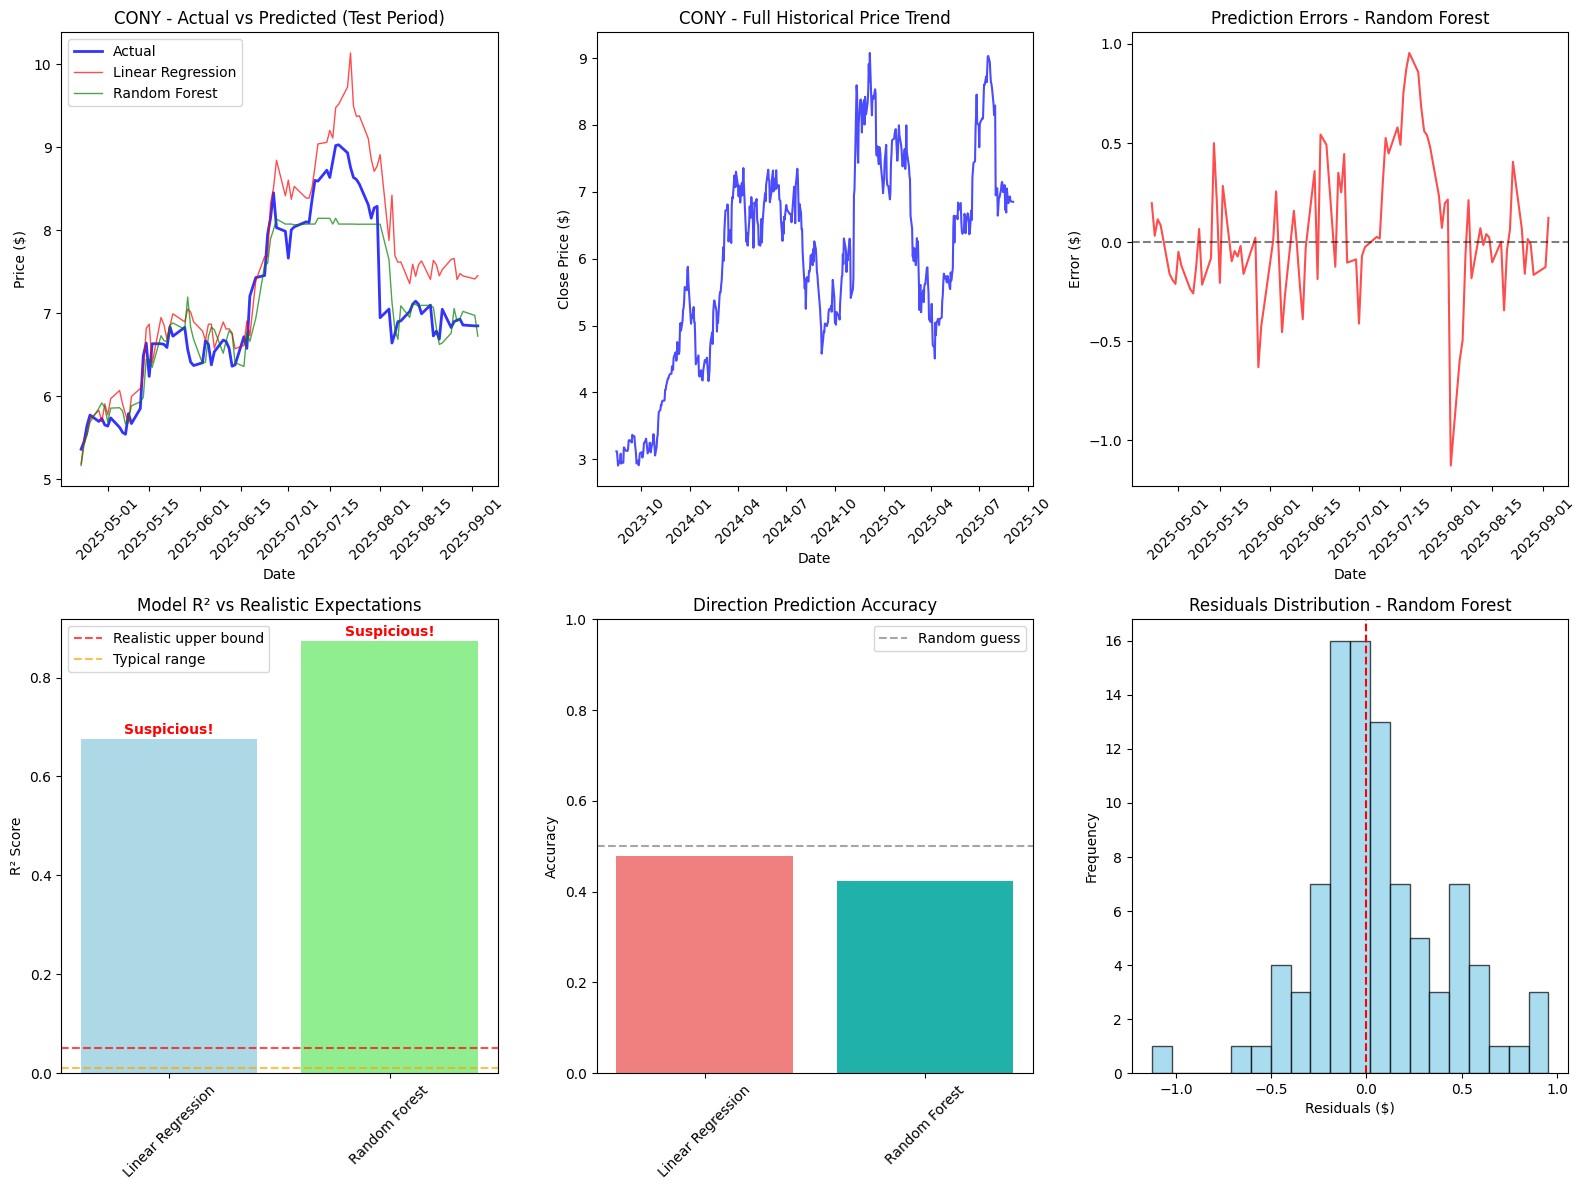


REALITY CHECK - CONY STOCK ANALYSIS
Data period: 5y
Total data points: 515
Latest close price: $6.85
Price volatility (std): $1.52

📊 MODEL PERFORMANCE INTERPRETATION:

Linear Regression:
  ⚠️  R² of 0.675 is UNREALISTICALLY HIGH for stock prediction
  💡 This likely indicates overfitting or data leakage
  📉 Direction accuracy of 47.8% is not better than random guessing

Random Forest:
  ⚠️  R² of 0.874 is UNREALISTICALLY HIGH for stock prediction
  💡 This likely indicates overfitting or data leakage
  📉 Direction accuracy of 42.4% is not better than random guessing

🎯 REMEMBER:
  • Stock markets are largely unpredictable
  • Professional traders struggle to consistently beat the market
  • High R² values (>10%) are suspicious in stock prediction
  • Focus on direction accuracy and risk management
  • This is for educational purposes only!


In [13]:
if __name__ == "__main__":
    main()